In [178]:
!pip install control

In [179]:
!pip install casadi

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import control
import csv
from IPython.display import clear_output
from scipy.integrate import odeint, solve_ivp
from casadi import *
from scipy.integrate import odeint

In [278]:
  #Contact data
with open("/contact.csv", 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
C = np.array(data, dtype=float)

#Pandemic parameters
lbd = np.array([0.05]*6)
gamr = np.array([0.7657411,0.7842402,0.8012127,0.9018488,0.2802379,0.5864928])
gamd = np.array([0.0015683025,0.004833996,0.09288585,0.09685946,0.17079121,0.56594825])

#Population data
N = np.array([1058304,915796,983789,384803,203035,99516])
n = len(N)
# Initial condition
I0 = 0.001*N
S = N-I0
I = I0
R = np.array([0]*n)
D = np.array([0]*n)
# Maximal number of vaccination per day
umax=55191

# Labels and age ranges
labels = ['Susceptibles', 'Infected', 'Recovered', 'Deceased']
ranges = ['[0,25)', '[25,45)', '[45,65)', '[65,75)', '[75,85)', '85+']


# 3 - Simulation and implementation of the standard protocol

## 3.1 - Given the system parameters of model (1), present in the python file, implement the continuous time COVID-19 pandemic system. The control input is the vaccinations rate in terms of number of suitable vaccinations per day, the state is the populations of susceptible, infected, recovered and deceased individuals.

In [279]:
'''
  Function to calculate the x dot function
'''

def dxdt(x,t,C, U, gamr, gamd, lbd):
  S=x[:6]
  I=x[6:12]
  dSkdt = -lbd*S*(C@I) - U
  dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
  dRdt = gamr*I + U
  dDdt = gamd*I

  return np.concatenate([dSkdt, dIkdt, dRdt, dDdt])

In [280]:
U = np.zeros_like(C@I) # For a first step, I can use the U = 0 to test the system
#x_dot  = dxdt(C, I, U, gamr, gamd, S, lbd)

In [281]:
def plot_rates_cont(k, dSkdt, dIkdt, dRdt, dDdt):
  fig, axs = plt.subplots(2, 2, layout='constrained')

  axs[0, 0].plot(np.arange(k) + 1, dSkdt)
  axs[0, 0].grid(True)
  axs[0, 0].set_xlabel("Age [k]")
  axs[0, 0].set_ylabel("Rate of suceptible people")

  axs[0, 1].plot(np.arange(k) + 1, dIkdt)
  axs[0, 1].grid(True)
  axs[0, 1].set_xlabel("Age [k]")
  axs[0, 1].set_ylabel("Rate of infected people")

  axs[1, 0].plot(np.arange(k) + 1, dRdt)
  axs[1, 0].grid(True)
  axs[1, 0].set_xlabel("Age [k]")
  axs[1, 0].set_ylabel("Rate of recovered people")

  axs[1, 1].plot(np.arange(k) + 1, dDdt)
  axs[1, 1].grid(True)
  axs[1, 1].set_xlabel("Age [k]")
  axs[1, 1].set_ylabel("Rate of deaths")

  plt.suptitle('Rates of infection system')
  plt.show()


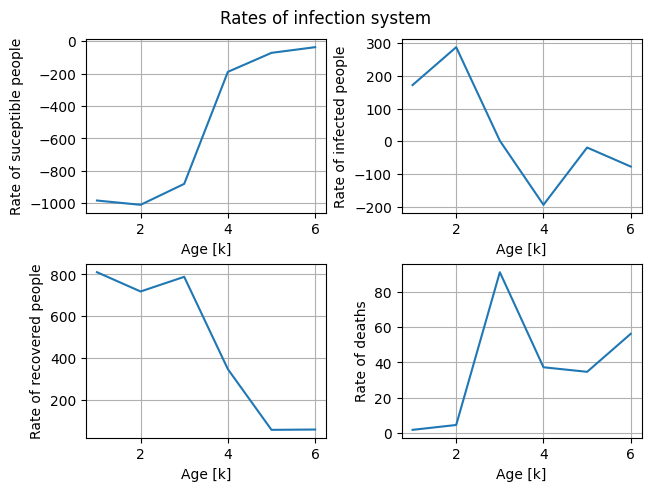

In [282]:
# To plot the rates

dSkdt = -lbd*S*(C@I) - U
dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
dRdt = gamr*I + U
dDdt = gamd*I

k = len(dSkdt)

plot_rates_cont(k, dSkdt, dIkdt, dRdt, dDdt)

In [283]:
def plot_x(S, I, R, D, ranges):
  fig, axs = plt.subplots(2, 2, layout='constrained', figsize = (20,10))
  colors = ['b', 'r', 'g', 'y', 'black', 'magenta']

  for i, age in enumerate(ranges):
    axs[0, 0].plot(S[:,i], colors[i], label = age)
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Evolution of Suceptible')
    axs[0, 0].set_xlabel("Time [days]")
    axs[0, 0].set_ylabel("People [un]")
    axs[0, 0].legend()

    axs[0, 1].plot(I[:,i], colors[i], label = age)
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Evolution of Infected')
    axs[0, 1].set_xlabel("Time [days]")
    axs[0, 1].set_ylabel("People [un]")
    axs[0, 1].legend()

    axs[1, 0].plot(R[:,i], colors[i], label = age)
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Evolution of Recovered')
    axs[1, 0].set_xlabel("Time [days]")
    axs[1, 0].set_ylabel("People [un]")
    axs[1, 0].legend()

    axs[1, 1].plot(D[:,i], colors[i], label = age)
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Evolution of Deaths')
    axs[1, 1].set_xlabel("Time [days]")
    axs[1, 1].set_ylabel("People [un]")
    axs[1, 1].legend()

  plt.suptitle('Evolution of the system through time')
  plt.show()

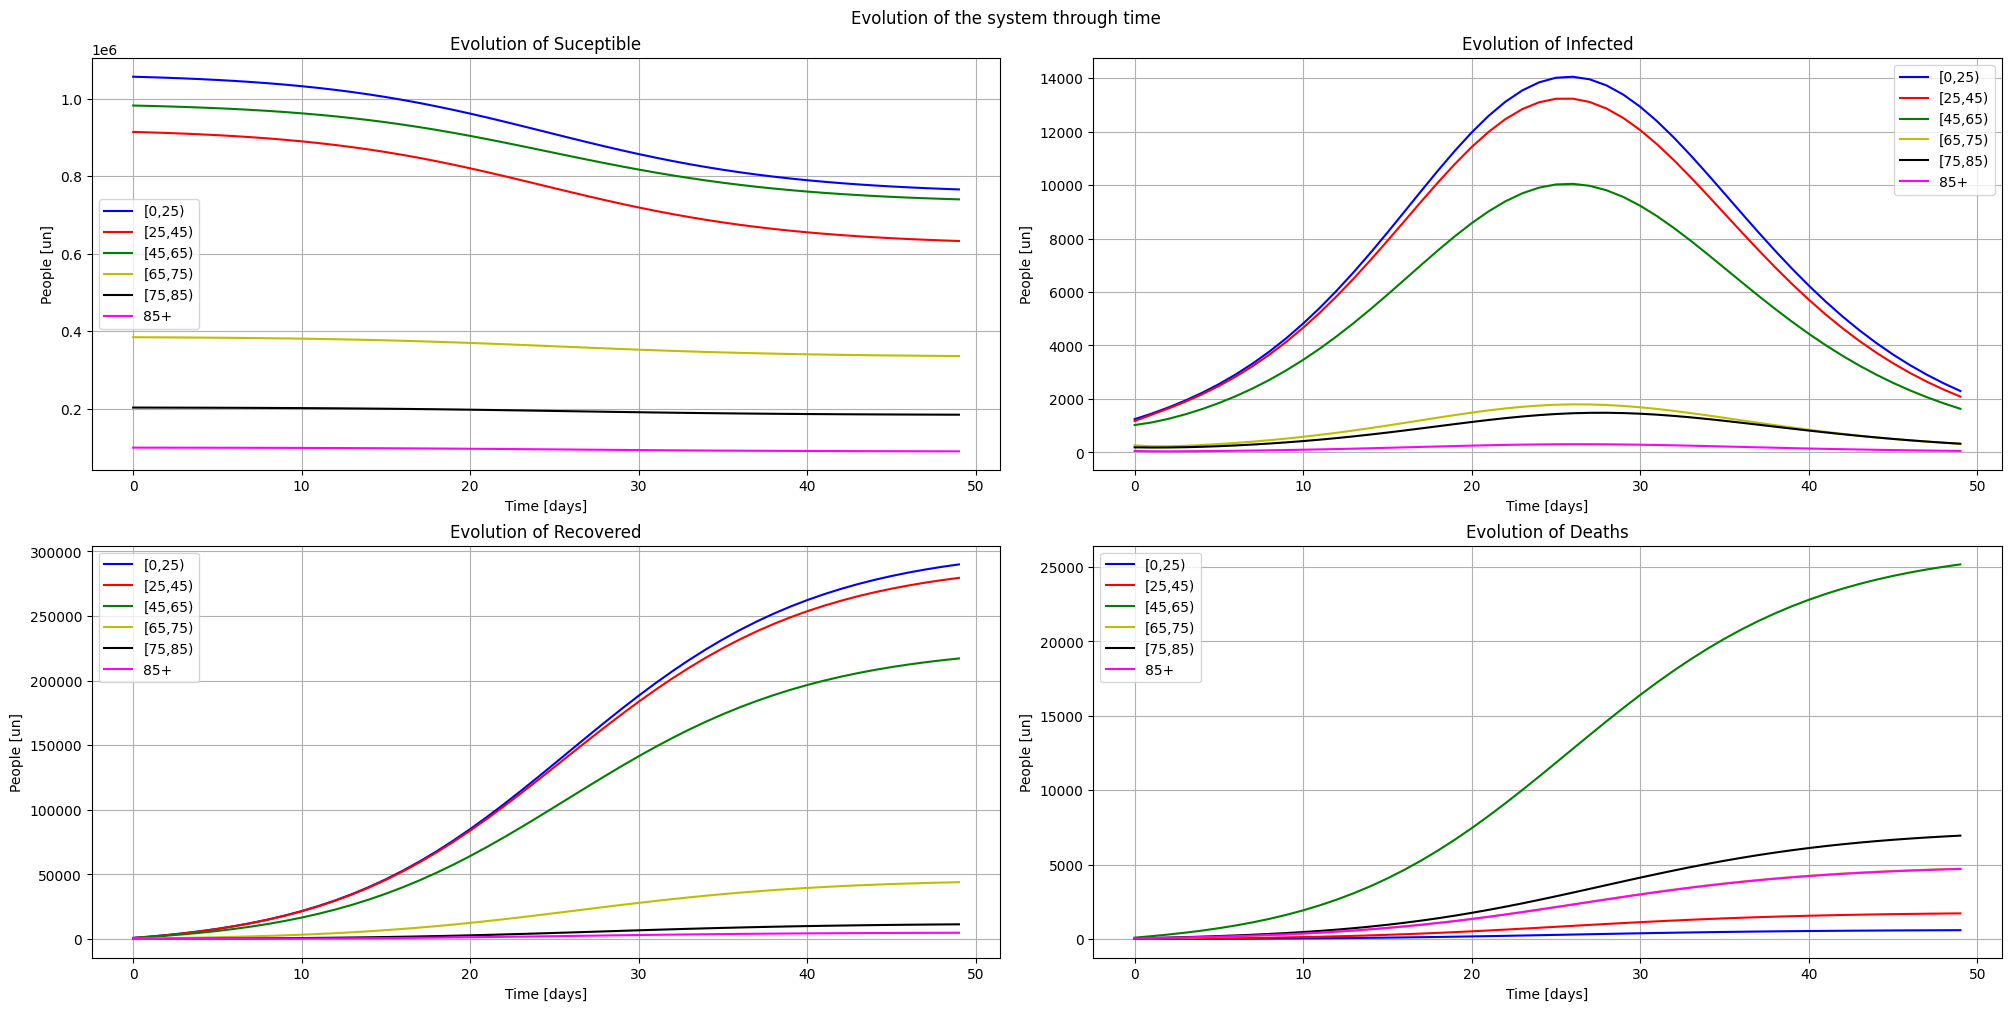

In [284]:
y0 = np.concatenate([S, I, R, D])
x = y0
U = np.array([0,0,0,
              0,0,0]) # For a first step, I can use the U = 0 to test the system

S_array = np.zeros(300).reshape(50,6)
I_array = np.zeros(300).reshape(50,6)
R_array = np.zeros(300).reshape(50,6)
D_array = np.zeros(300).reshape(50,6)


for day in range(50):
  x = odeint(dxdt, x, [0,1], args=(C, U, gamr, gamd, lbd))
  x = x[1]
  S_array[day] = x[:6]
  I_array[day] = x[6:12]
  R_array[day] = x[12:18]
  D_array[day] = x[18:24]

plot_x(S_array, I_array, R_array, D_array, ranges)

## 3.2.i -  supposing that the vaccination takes place in continuous time, along the whole day. This would mean to determine U(t) for t ∈ R and apply it to (1), that is then a function of the time. The continuous-time model is then simulated day by day.


In [302]:
def calculate_u(umax, S, u):
  un=umax
  n = len(U)
  for i in range(n-1,-1,-1):
      if S[i] > 0:
          u[i] = np.minimum(S[i],un)
          un = un - u[i]
  return u

In [303]:
'''
  Function to calculate the x dot function
'''

def dxdt2(x,t,C, gamr, gamd, lbd):

  S=x[:6]
  I=x[6:12]

  umax=55191
  U = np.zeros(6)
  U = calculate_u(umax, S, U)


  dSkdt = -lbd*S*(C@I) - U
  dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
  dRdt = gamr*I + U
  dDdt = gamd*I

  return np.concatenate([dSkdt, dIkdt, dRdt, dDdt])

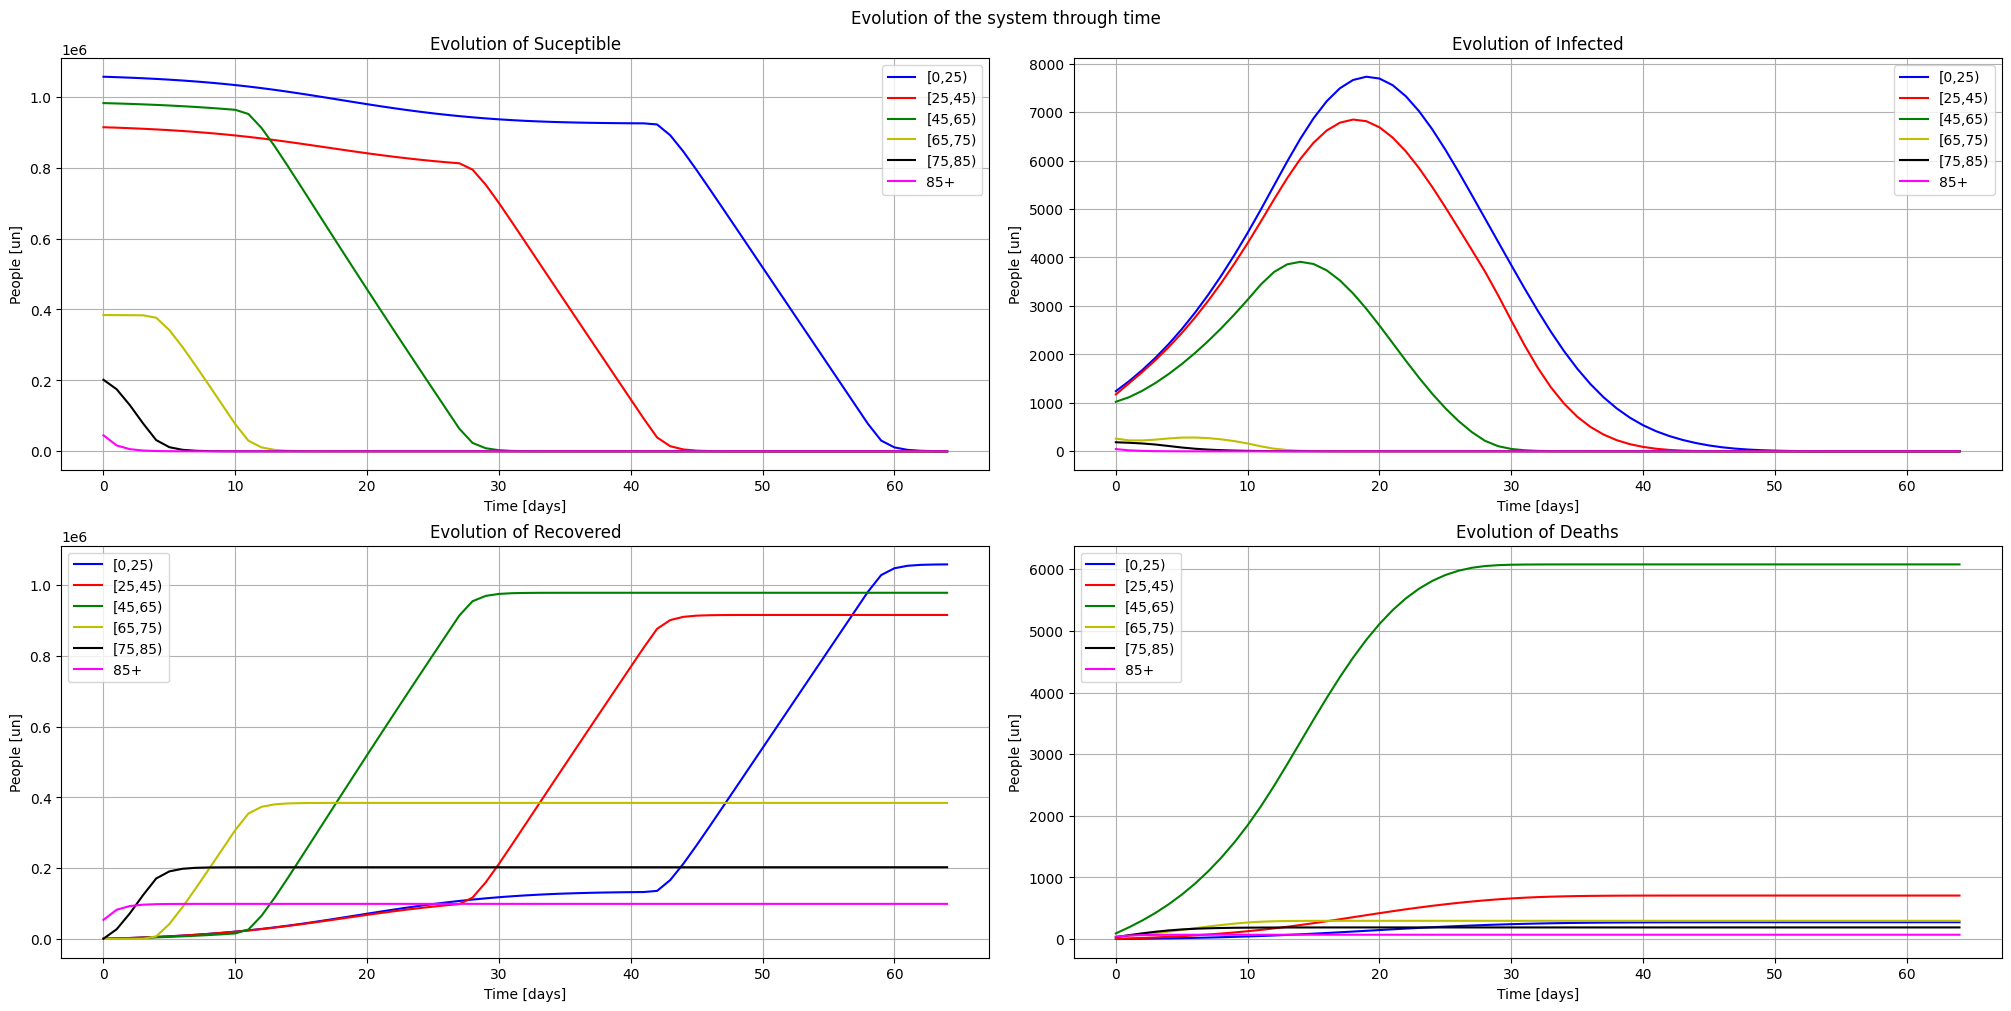

In [304]:
y0 = np.concatenate([S, I, R, D])
x = y0

S_array = np.zeros(days * divisions).reshape(days,6)
I_array = np.zeros(days * divisions).reshape(days,6)
R_array = np.zeros(days * divisions).reshape(days,6)
D_array = np.zeros(days * divisions).reshape(days,6)


x = odeint(dxdt2, x, [0,1], args=(C, gamr, gamd, lbd))

S_array[day] = x[:6]
I_array[day] = x[6:12]
R_array[day] = x[12:18]
D_array[day] = x[18:24]

plot_x(S_array, I_array, R_array, D_array, ranges)

## 3.2.ii - suppose that the whole admissible amount of daily vaccinations Umax is administered instantaneously at the beginning of every day. An appropriate value of Uk(n) is computed for all k-th age range with k = 1, . . . , na such that their summation is equal to Umax and the older susceptible individuals are vaccinated first. After the instantaneous update of the number of susceptibles and recovered, the system (1) is simulated in open loop till the following day.

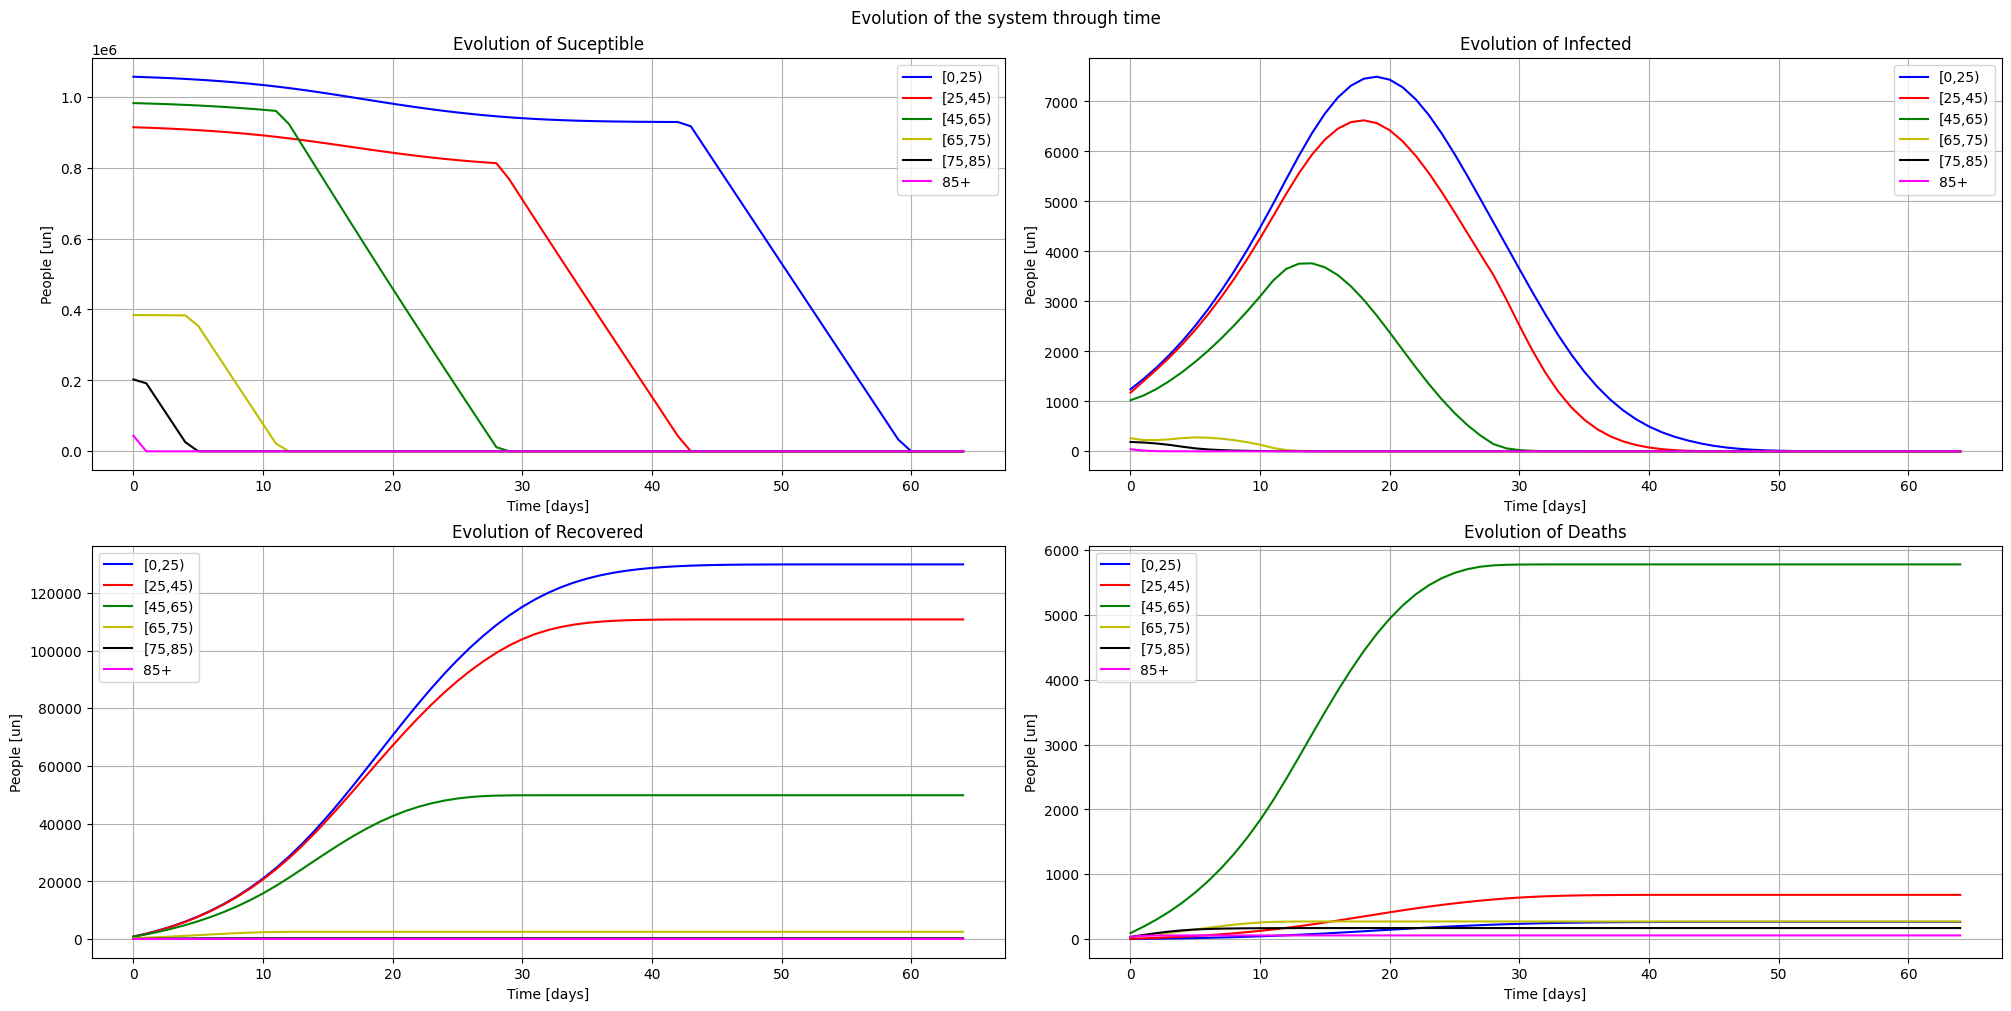

In [312]:
y0 = np.concatenate([S, I, R, D])
x = y0
days = 65
divisions = len(ranges)

S_array = np.zeros(days * divisions).reshape(days,6)
I_array = np.zeros(days * divisions).reshape(days,6)
R_array = np.zeros(days * divisions).reshape(days,6)
D_array = np.zeros(days * divisions).reshape(days,6)


for day in range(days):
  Sk = x[:6]
  U = np.zeros(6)
  U = calculate_u(umax, Sk, U)
  x[:6] = x[:6] - U
  x = odeint(dxdt, x, [0,1], args=(C, 0, gamr, gamd, lbd))
  x = x[1]
  S_array[day] = x[:6]
  I_array[day] = x[6:12]
  R_array[day] = x[12:18]
  D_array[day] = x[18:24]

plot_x(S_array, I_array, R_array, D_array, ranges)

In [311]:
np.linspace(0,49, 500)

array([ 0.        ,  0.09819639,  0.19639279,  0.29458918,  0.39278557,
        0.49098196,  0.58917836,  0.68737475,  0.78557114,  0.88376754,
        0.98196393,  1.08016032,  1.17835671,  1.27655311,  1.3747495 ,
        1.47294589,  1.57114228,  1.66933868,  1.76753507,  1.86573146,
        1.96392786,  2.06212425,  2.16032064,  2.25851703,  2.35671343,
        2.45490982,  2.55310621,  2.65130261,  2.749499  ,  2.84769539,
        2.94589178,  3.04408818,  3.14228457,  3.24048096,  3.33867735,
        3.43687375,  3.53507014,  3.63326653,  3.73146293,  3.82965932,
        3.92785571,  4.0260521 ,  4.1242485 ,  4.22244489,  4.32064128,
        4.41883768,  4.51703407,  4.61523046,  4.71342685,  4.81162325,
        4.90981964,  5.00801603,  5.10621242,  5.20440882,  5.30260521,
        5.4008016 ,  5.498998  ,  5.59719439,  5.69539078,  5.79358717,
        5.89178357,  5.98997996,  6.08817635,  6.18637275,  6.28456914,
        6.38276553,  6.48096192,  6.57915832,  6.67735471,  6.77